# Import

In [1]:
import sys

root_dir = '../../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Output settings

In [2]:
out_to_file = False
out_dir = '../../out/comparison/ml_100k/'

# Dataset

In [3]:
dataset = datasets.ML100k()
n_user = dataset.n_user
n_item = dataset.n_item
n_feedback = dataset.n_pos_pairs
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

In [4]:
print(f'n_user = {n_user}')
print(f'n_item = {n_item}')
print(f'n_feedback = {n_feedback}')

n_user = 940
n_item = 1447
n_feedback = 55369


# Device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

In [6]:
print(device)

cpu


# Evaluator

In [7]:
# The size of recommendation set (K)
ks = [10]

score_function_dict = {
    "Recall"       : evaluators.recall,
    "Unpopularity" : evaluators.unpopularity,
    "Serendipity"  : evaluators.serendipity,
    "Long-tail rate": evaluators.longtail_rate,
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
coverage = evaluators.CoverageEvaluator(test_set, ks)

# Sampler

In [8]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [9]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# Result (before training)

In [10]:
knn = searches.NearestNeighborhood(model)

In [11]:
# userwise
trainer.valid(knn, userwise)
re_userwise = trainer.valid_scores.copy()

In [12]:
# coverage
trainer.valid(knn, coverage)
re_coverage = trainer.valid_scores.copy()

In [13]:
re_pre = pd.concat([re_userwise, re_coverage], axis=1)

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("pre_%Y_%m_%d_%H%M.csv")
    re_no_training.to_csv(file_name, index=False)

display(re_pre)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10,Coverage@10
0,0.131438,309.498642,3.490856,0.771489,0.307533


# Training

In [14]:
trainer.fit(n_batch, n_epoch)

# Result

## CML (Base)

In [15]:
knn = searches.NearestNeighborhood(model)

In [16]:
# userwise
trainer.valid(knn, userwise)
re_userwise = trainer.valid_scores.copy()

In [17]:
# coverage
trainer.valid(knn, coverage)
re_coverage = trainer.valid_scores.copy()

In [18]:
re_base = pd.concat([re_userwise, re_coverage], axis=1)

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("base_%Y_%m_%d_%H%M.csv")
    re_base.to_csv(file_name, index=False)

display(re_base)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10,Coverage@10
0,0.570561,28.76039,6.967271,0.179043,0.234969


# MPCMP

In [19]:
# Hyperparameters
n_sample = 30
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [20]:
rows = []
for bias in bias_li:
    print(f'Prosessing... [bias = {bias}]')
    
    mp = searches.MutualProximity(model, gamma, n_sample, bias)
    
    # userwise
    trainer.valid(mp, userwise)
    re_userwise = trainer.valid_scores.copy()
    
    # coverage
    trainer.valid(mp, coverage)
    re_coverage = trainer.valid_scores.copy()
    
    row = pd.concat([re_userwise, re_coverage], axis=1)
    row.insert(0, 'Bias', bias)
    
    rows.append(row)

re_mpcml = pd.concat(rows)

Prosessing... [bias = 0.0]
Prosessing... [bias = 0.1]
Prosessing... [bias = 0.2]
Prosessing... [bias = 0.3]
Prosessing... [bias = 0.4]
Prosessing... [bias = 0.5]
Prosessing... [bias = 0.6]
Prosessing... [bias = 0.7]
Prosessing... [bias = 0.8]
Prosessing... [bias = 0.9]
Prosessing... [bias = 1.0]


In [21]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_%Y_%m_%d_%H%M.csv")
    re_base.to_csv(file_name, index=False)

display(re_mpcml)

,Bias,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10,Coverage@10
0,0.0,0.362770,186.095342,10.003367,0.623617,0.277816
0,0.1,0.404659,122.456903,9.475745,0.552340,0.263994
0,0.2,0.432277,98.618913,9.542335,0.511277,0.259848
0,0.3,0.453027,82.057078,9.335102,0.468298,0.257775
0,0.4,0.473012,70.774359,9.264568,0.437979,0.258466
0,0.5,0.489735,61.194280,9.076621,0.404149,0.252937
0,0.6,0.502561,54.591994,8.899480,0.375000,0.255010
0,0.7,0.515674,48.348977,8.732745,0.338830,0.256393
0,0.8,0.531838,42.361552,8.464395,0.303936,0.257775
0,0.9,0.546857,35.553762,8.028193,0.254894,0.252246


## CML vs MPCML

In [22]:
# df -> list

k = 10
n_bias = len(bias_li)

# Before training
recall_pre         = re_pre[f'Recall@{k}'].tolist() * n_bias
unpopularity_pre   = re_pre[f'Unpopularity@{k}'].tolist() * n_bias
serndipity_pre     = re_pre[f'Serendipity@{k}'].tolist() * n_bias
longtale_pre       = re_pre[f'Long-tail rate@{k}'].tolist() * n_bias
coverage_pre       = re_pre[f'Coverage@{k}'].tolist() * n_bias

# CML(Base)
recall_base        = re_base[f'Recall@{k}'].tolist() * n_bias
unpopularity_base  = re_base[f'Unpopularity@{k}'].tolist() * n_bias
serndipity_base    = re_base[f'Serendipity@{k}'].tolist() * n_bias
longtale_base      = re_base[f'Long-tail rate@{k}'].tolist() * n_bias
coverage_base      = re_base[f'Coverage@{k}'].tolist() * n_bias

# MPCML
recall_mpcml       = re_mpcml[f'Recall@{k}'].tolist()
unpopularity_mpcml = re_mpcml[f'Unpopularity@{k}'].tolist()
serndipity_mpcml   = re_mpcml[f'Serendipity@{k}'].tolist()
longtale_mpcml     = re_mpcml[f'Long-tail rate@{k}'].tolist()
coverage_mpcml     = re_mpcml[f'Coverage@{k}'].tolist()

### Recall vs Unpopularity

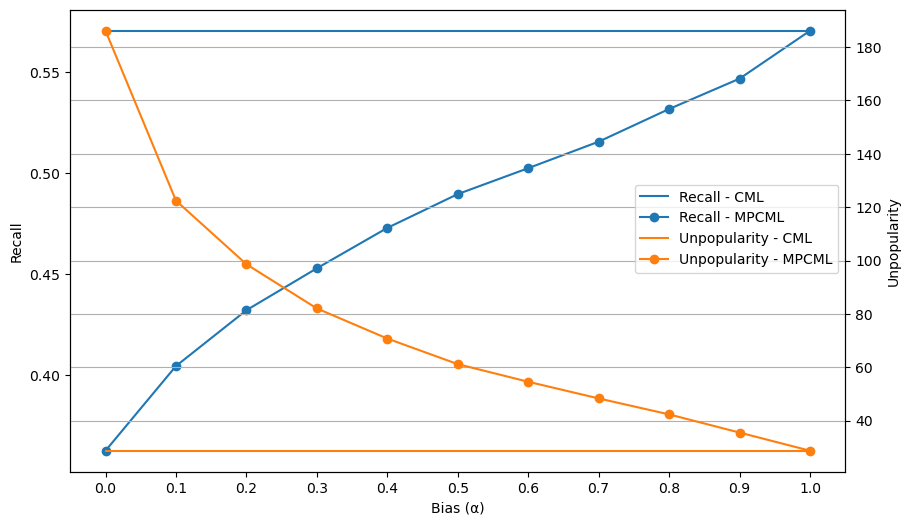

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Recall
line_recall_base  = ax1.plot(bias_li, recall_base,  label='Recall - CML', color='tab:blue')
line_recall_mpcml = ax1.plot(bias_li, recall_mpcml, label='Recall - MPCML', marker='o', color='tab:blue')

# Unpopularity
ax2 = ax1.twinx()
line_unpop_base  = ax2.plot(bias_li, unpopularity_base,  label='Unpopularity - CML', color='tab:orange')
line_unpop_mpcml = ax2.plot(bias_li, unpopularity_mpcml, label='Unpopularity - MPCML', marker='o', color='tab:orange')

ax1.set_xticks(bias_li)
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.set_xlabel('Bias (α)')
ax1.set_ylabel('Recall')
ax2.set_ylabel('Unpopularity')

lines = [line_recall_base[0], line_recall_mpcml[0], line_unpop_base[0], line_unpop_mpcml[0]]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, bbox_to_anchor=(0.9, 0.6))

plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("tradeoff_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Serendipity

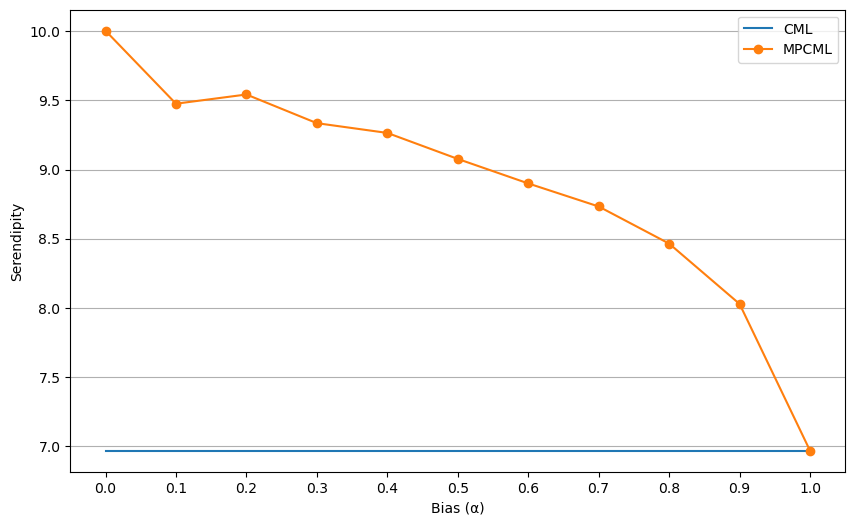

In [24]:
plt.figure(figsize=(10, 6))
# plt.plot(bias_li, serndipity_pre, label='Before training)
plt.plot(bias_li, serndipity_base, label='CML')
plt.plot(bias_li, serndipity_mpcml, label='MPCML', marker='o')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Serendipity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("serendipity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Long-tail rate

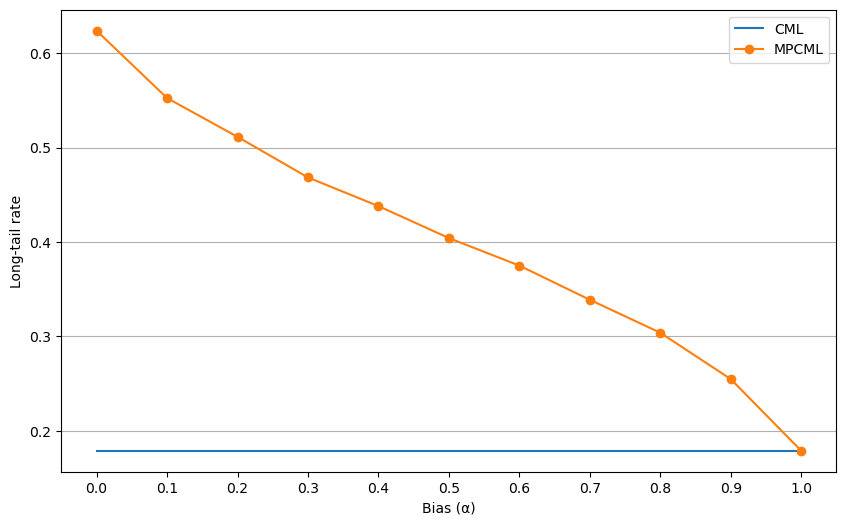

In [25]:
plt.figure(figsize=(10, 6))
# plt.plot(bias_li, longtale_pre, label='Before training')
plt.plot(bias_li, longtale_base, label='CML')
plt.plot(bias_li, longtale_mpcml, label='MPCML', marker='o')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Long-tail rate')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("longtail_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Coverage

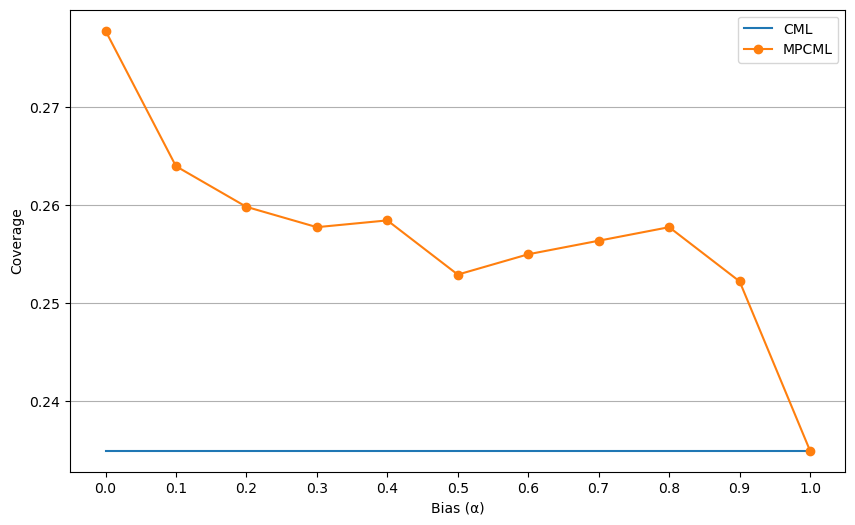

In [26]:
plt.figure(figsize=(10, 6))
# plt.plot(bias_li, longtale_pre, label='Before training', linestyle='--')
plt.plot(bias_li, coverage_base, label='CML')
plt.plot(bias_li, coverage_mpcml, label='MPCML', marker='o')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Coverage')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("coverage_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()